# TrES-3b transmission spectroscopy: light curve creation

*<a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a>, University of Oxford*

Here we create the broad- and narrow-band light curves from the reduced spectra, and create a set of plots for the paper.

This notebook is a part in a series of notebooks working as an appendix to Parviainen et al. (2015, submitted), aiming to make the analysis presented in the paper easily reproductable. The results and the figures presented in the paper can be reproduced by following these notebooks in the numbered order.

*Dependencies:* See `000_README.ipynb` for the list of required Python packages, and how to install them.

## Overview

### Data

We start with the spectra reduced by G. Nowak stored in directory `data/spectra`. The wavelength solution is calculated in [001_Wavelength_calibration.ipynb](001_Wavelength_calibration.ipynb), and stored as a pickle in `results/wl_calibration.pkl`.

 - The comparison star is on CCD 1
 - The target star is on CCD 2

### Filters

The light curves are generated for 16 narrow passbands, defined in `core.py`, and for a broad 'white' passband.  The passbands are defined using a [generalized Gaussian](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.general_gaussian.html#scipy.signal.general_gaussian) window function.
$$
F(x) = e^{- \frac{1}{2} \left|\frac{x-c}{\sigma}\right|^{2p}}.
$$

**Spectrum masking:** Some regions of the spectrum (the cores of the telluric absorption bands) were observed to increase the light curve noise level significantly during the initial analysis. We create a set of masked light curves to test whether this has an effect on the parameter estimates (spoiler: yes, it does).

### Output

The light curves with the auxiliary data are saved as Pandas tables in a HDF5 file `results/light_curves.h5`. The file structure is

 - `/aux`
 - `/filters`
 - `/bad_exposures`
 - `/final/XX_YYYYYY`
 - `/reference/XX_YYYYYY`
 - `/target/XX_YYYYYY`

where `XX` is `nb` for narrow-band light curves and `bb` for broadband light curves, and `YYYYYY` is `nomask` for the unmasked LCs and `masked` for the masked LCs. 

### Plots

Finally, the notebook generates plots for the paper Parviainen (2015).

## Initialisation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyfits as pf
from glob import glob
from pandas import DataFrame as DF
from astropy.time import Time
from scipy.signal import medfilt as mf
from scipy.ndimage import binary_erosion

from core import *

def normalise(lc):
    msk = ones(spectra_2.shape[0], np.bool)
    msk[45:190] = False
    return lc / median(lc[msk])

## Import the spectra

In [3]:
data_dir = 'data/spectra/'
sfiles_1 = sorted(glob(join(data_dir,'*_1.ms.fits')))
sfiles_2 = sorted(glob(join(data_dir,'*_2.ms.fits')))

In [25]:
spectra_1 = array([pf.getdata(sf, ) for sf in sfiles_1]).astype(np.float64)
spectra_2 = array([pf.getdata(sf) for sf in sfiles_2]).astype(np.float64)

## Read in the wavelength solutions 

The spectra have been extracted using a subsection from the original CCD (also along the dispersion axis), this must be accounted for when calculating the wavelength table.

In [5]:
wls = load(join('results','wl_calibration.pkl'), 'r')
ccdsec = eval('['+pf.getval(sfiles_2[0],'ccdsec').split(',')[-1].replace(':',','))
pixels = arange(ccdsec[0], ccdsec[1]+1)

wl1 = wls['ccd1'].pixel_to_wl(pixels)
wl2 = wls['ccd2'].pixel_to_wl(pixels)

## Plot the spectra 

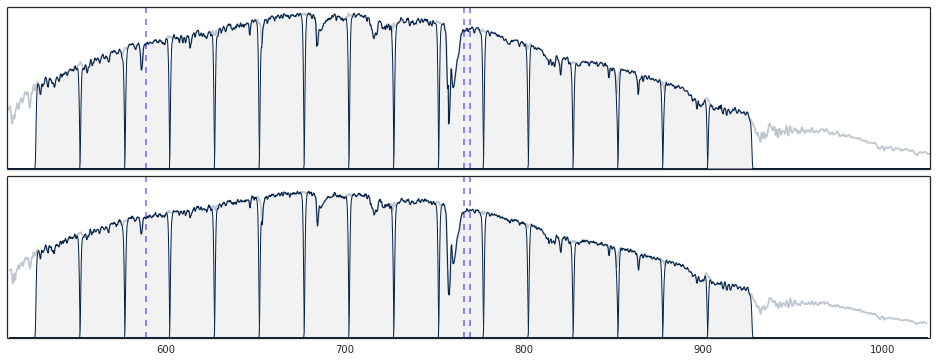

In [6]:
fig,axs = subplots(2,1, sharey=True, sharex=True)
wls = [wl1,wl2]
sps = [normalise(spectra_1[0]),normalise(spectra_2[0])]
aws = zip(axs,wls,sps)
[ax.plot(wl, sp, c=cp[0], alpha=0.25, zorder=1) for ax,wl,sp in aws]
[[ax.fill(wl, f(wl)*sp, ec=cp[0], lw=1, fc='0.95', zorder=0) for f in pb_filters_nb] for ax,wl,sp in aws]
[[a.axvline(wlc, ls='--', alpha=0.5, zorder=2) for wlc in r_[wlc_na,wlc_k]] for a in axs]
setp(axs, xlim=(wl1[[0,-1]]), ylim=(0,1.6), yticks=[])
fig.tight_layout()

## Create the spectrum mask

Telluric absorption can cause significant increase of noise in the narrow-band light curves. Here we create masks that remove the cores of the telluric absorption lines from the spectra. 

In [7]:
def create_mask(s, lims=None, elim=None, erosion_iterations=2, plot=True, figsize=(13,8), fs=12):
    x = arange(s.shape[0])
    if lims:
        tmask = (x < lims[0]) | (x > lims[1])
    else:
        tmask = ones(x.size, np.bool)
        
    p = poly1d(polyfit(x[tmask], s[tmask,:].mean(1), 4))
    
    lc_std = (s[tmask,:]/p(x[tmask])[:,newaxis]).std(0)
    smask  = binary_erosion(lc_std < elim, iterations=erosion_iterations, border_value=1)
    
    if plot:
        fig = figure(figsize=figsize)
        gs = GridSpec(2,2, width_ratios=(0.85,0.15), height_ratios=(0.6,0.4))
        axs = ae, ai, at = subplot(gs[0,0]), subplot(gs[1,0]), subplot(gs[1,1])
        ai.imshow(s, aspect='auto', interpolation='nearest', origin='lower')
       
        ae.plot(lc_std)
        ae.plot(0.035 + where(smask, lc_std, nan))
        ae.plot(where(smask, nan, -0.005), lw=3, c='k')   

        spec  = (s[tmask,:]/p(x[tmask])[:,newaxis]).mean(0)
        spec -= spec.min()
        spec /= spec.max()
        ae.plot(0.12+0.15*spec, alpha=0.5, c=cp[2])
        
        at.plot(s.mean(1), x, alpha=0.5)
        at.plot(p(x), x, 'k--', alpha=0.5)

        if lims is not None:
            ai.axhspan(*lims, ec='k', lw=2, fill=False, alpha=0.5)
            ai.axhspan(*lims, fc='w', ec='w', lw=1, fill=True, alpha=0.25)
            at.axhspan(*lims, ec='k', lw=2, fill=False, alpha=0.5)
            at.axhspan(*lims, fc='w', fill=True, alpha=0.25)

        if elim:
            ae.axhline(elim, ls='-', c=c_bo, alpha=0.25, zorder=-100)

        ae.text(0.01,0.94,'a', transform=ae.transAxes, size=fs)
        ai.text(0.97,0.88,'b', transform=ai.transAxes, size=fs)
        at.text(0.85,0.88,'c', transform=at.transAxes, size=fs)
            
        setp(ai, xlim=[0,s.shape[1]], ylim=x[[0,-1]], ylabel='Exposure', xlabel='Pixel')
        setp(ae, xlim=[0,s.shape[1]], xticks=[], ylim=(-0.015,0.28), ylabel='Normalized flux')
        setp(at, ylim=x[[0,-1]], yticks=[], xticks=[], xlabel='Relative flux')

        fig.tight_layout()
        sb.despine(ax=ae)
    
    return smask if not plot else smask,fig,axs

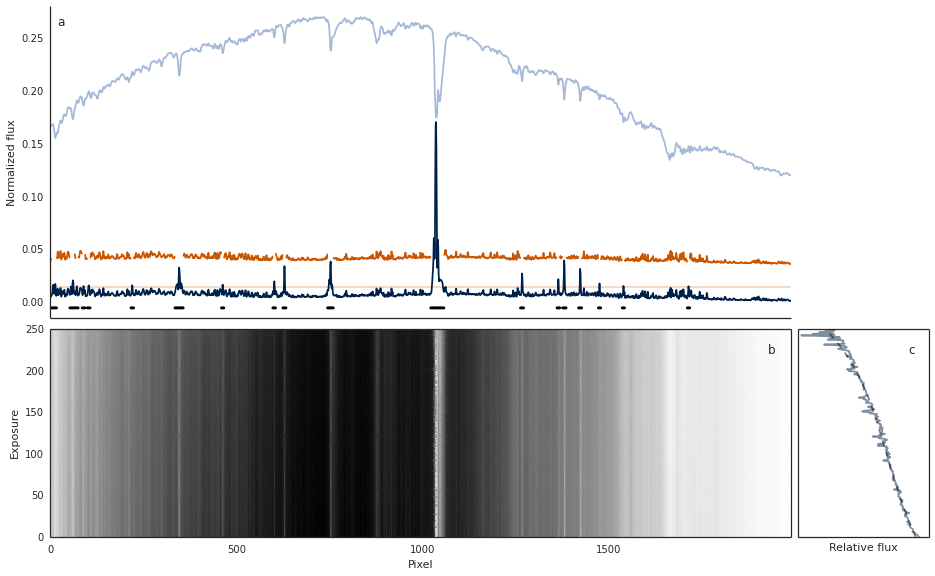

In [8]:
m1,f1,a1 = create_mask(spectra_1/median(spectra_1), elim=0.015, erosion_iterations=3)

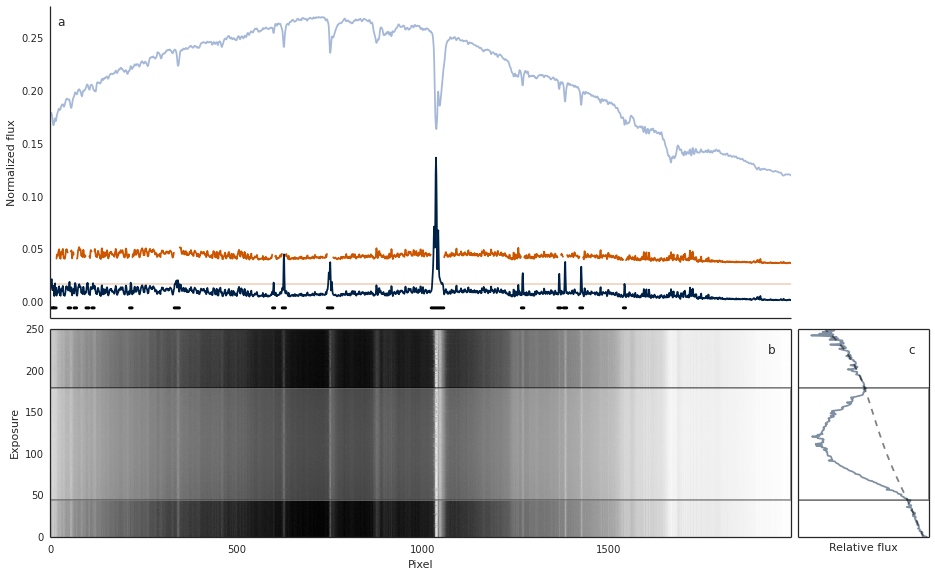

In [9]:
m2,f2,a2 = create_mask(spectra_2/median(spectra_2), lims=(45,180), elim=0.0175, erosion_iterations=3)

## Create the bad-point mask 

In [10]:
bmsk = ones(spectra_1.shape[0], np.bool)
bmsk[[151,152]] = 0
bmsk[230:] = 0

## Create the light curves

The light curves are name as `lc_BB_N_MMMMMM` where `BB` is either `nb` for a narrow band or `bb` for the broad passband, `N` is 1 for the reference star and `2` for TrES-3, and `MMMMMM` is either `mask` or `nomask`.

In [11]:
lc_nb_1_nomask = array([[mean(f(wl1)*s) for f in pb_filters_nb] for s in spectra_1])
lc_nb_2_nomask = array([[mean(f(wl2)*s) for f in pb_filters_nb] for s in spectra_2])

In [12]:
lc_nb_1_masked = array([[nanmean(f(wl1)*where(m1,s,nan)) for f in pb_filters_nb] for s in spectra_1])
lc_nb_2_masked = array([[nanmean(f(wl2)*where(m2,s,nan)) for f in pb_filters_nb] for s in spectra_2])

In [13]:
lc_bb_1_nomask = array([mean(pb_filter_bb(wl1)*s) for s in spectra_1])
lc_bb_2_nomask = array([mean(pb_filter_bb(wl2)*s) for s in spectra_2])
lc_bb_1_masked = array([nanmean(pb_filter_bb(wl1)*where(m1,s,nan)) for s in spectra_1])
lc_bb_2_masked = array([nanmean(pb_filter_bb(wl2)*where(m2,s,nan)) for s in spectra_2])

In [14]:
lc_bb_nomask = normalise(lc_bb_2_nomask/lc_bb_1_nomask)
lc_bb_masked = normalise(lc_bb_2_masked/lc_bb_1_masked)
lc_nb_nomask = array([normalise(lc) for lc in (lc_nb_2_nomask/lc_nb_1_nomask).T]).T
lc_nb_masked = array([normalise(lc) for lc in (lc_nb_2_masked/lc_nb_1_masked).T]).T

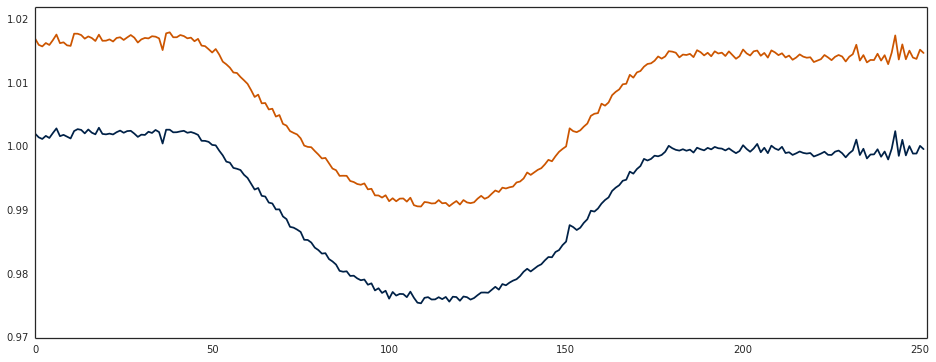

In [15]:
fig,ax = subplots(1,1)
ax.plot(normalise(lc_bb_2_nomask/lc_bb_1_nomask))
ax.plot(0.015+normalise(lc_bb_2_masked/lc_bb_1_masked))
setp(ax, xlim=[0,lc_nb_2_nomask.shape[0]], ylim=[0.97,1.022])
fig.tight_layout()

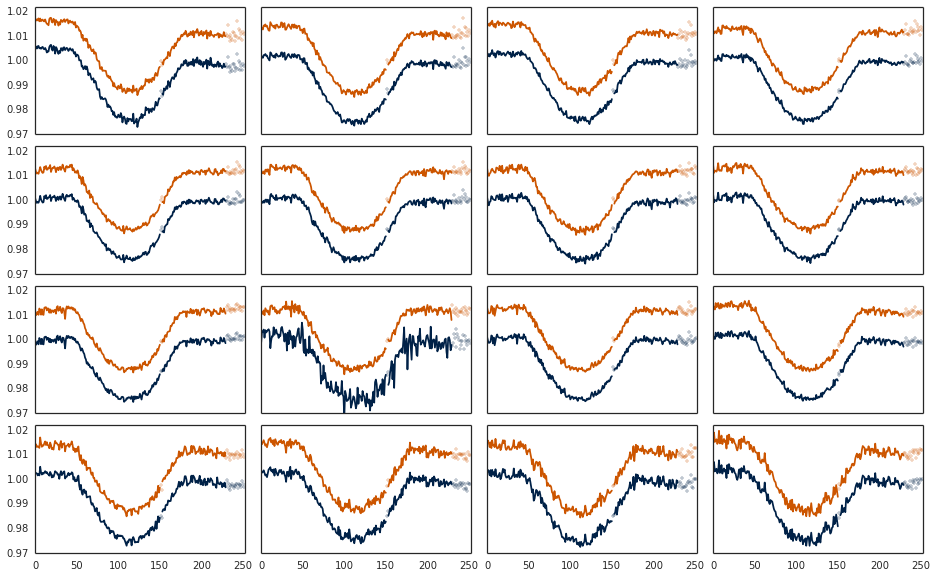

In [16]:
fig,axs = subplots(4,4,figsize=(13,8), sharey=True, sharex=True)
for i,a in enumerate(axs.flat):
    lcr =  normalise(lc_nb_2_nomask[:,i]/lc_nb_1_nomask[:,i])
    lcm =  normalise(lc_nb_2_masked[:,i]/lc_nb_1_masked[:,i])
    a.plot(where(bmsk, lcr, nan), c=cp[0])
    a.plot(where(bmsk, nan, lcr), '.', c=cp[0], alpha=0.25)
    a.plot(where(bmsk, 0.012+lcm, nan), c=cp[1])
    a.plot(where(bmsk, nan, 0.012+lcm), '.', c=cp[1], alpha=0.25)
setp(axs, xlim=[0,lc_nb_2_nomask.shape[0]], ylim=[0.97,1.022])
fig.tight_layout()

## Get the auxiliary parameters

In [17]:
time, airmass, humidity, pressure = [],[],[],[]

for fn in sfiles_1:
    f = pf.open(fn)
    time.append(f[0].header['date-obs'])
    airmass.append(f[0].header['airmass'])
    humidity.append(f[0].header['humidity'])
    pressure.append(f[0].header['pressure'])
    f.close()
mjd = Time(time).mjd

df_aux = pd.DataFrame(transpose([mjd,airmass,humidity,pressure,bmsk]), 
                  columns='mjd airmass humidity pressure bad_mask'.split())

In [18]:
df_filters = pd.DataFrame(transpose([f(wl2) for f in pb_filters_nb]), columns=pb_centers)

## Write the light curves and the auxiliary data into a HDF5 file 

In [19]:
bbargs = dict(columns=['white'], index=mjd)
nbargs = dict(columns=pb_centers, index=mjd)

hdf = pd.HDFStore('results/light_curves.h5')
hdf.put('aux', df_aux, format='table', data_columns=True)
hdf.put('filters', df_aux, format='table', data_columns=True)
hdf.put('bad_exposures', pd.Series(bmsk), format='table')
hdf.put('final/bb_nomask',     DF(lc_bb_nomask,   **bbargs), format='table', data_columns=True)
hdf.put('final/bb_masked',     DF(lc_bb_masked,   **bbargs), format='table', data_columns=True)
hdf.put('final/nb_nomask',     DF(lc_nb_nomask,   **nbargs), format='table', data_columns=True)
hdf.put('final/nb_masked',     DF(lc_nb_masked,   **nbargs), format='table', data_columns=True)
hdf.put('target/bb_nomask',    DF(lc_bb_2_nomask, **bbargs), format='table', data_columns=True)
hdf.put('target/bb_masked',    DF(lc_bb_2_masked, **bbargs), format='table', data_columns=True)
hdf.put('target/nb_nomask',    DF(lc_nb_2_nomask, **nbargs), format='table', data_columns=True)
hdf.put('target/nb_masked',    DF(lc_nb_2_masked, **nbargs), format='table', data_columns=True)
hdf.put('reference/bb_nomask', DF(lc_bb_1_nomask, **bbargs), format='table', data_columns=True)
hdf.put('reference/bb_masked', DF(lc_bb_1_masked, **bbargs), format='table', data_columns=True)
hdf.put('reference/nb_nomask', DF(lc_nb_1_nomask, **nbargs), format='table', data_columns=True)
hdf.put('reference/nb_masked', DF(lc_nb_1_nomask, **nbargs), format='table', data_columns=True)
hdf.close()

## Create the plots for the paper

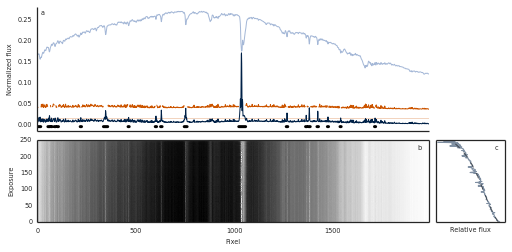

In [20]:
with sb.plotting_context('paper', rc=rc_paper):
    m1,f1,a1 = create_mask(spectra_1/median(spectra_1), elim=0.015,
                           erosion_iterations=3, figsize=(AAPGW,AAOCW), fs=6.5)
    f1.savefig('plots/pub_smask_c.pdf')

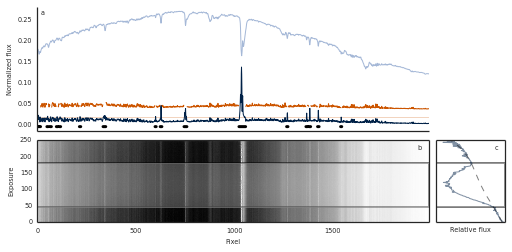

In [21]:
with sb.plotting_context('paper', rc=rc_paper):
    m2,f2,a2 = create_mask(spectra_2/median(spectra_2), lims=(45,180), elim=0.0175, 
                           erosion_iterations=3, figsize=(AAPGW,AAOCW), fs=6.5)
    f2.savefig('plots/pub_smask_t.pdf')

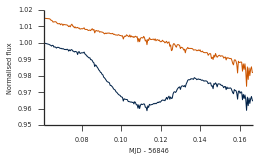

In [22]:
with sb.plotting_context('paper', rc=rc_paper):
    with sb.axes_style('ticks'):
        time = array(df_aux.mjd) - floor(df_aux.mjd[0])
        fig,ax = subplots(1,1, figsize=(AAOCW,0.6*AAOCW))
        ax.plot(time, lc_bb_2_nomask/lc_bb_2_nomask[0], c=c_ob, lw=1)
        ax.plot(time, lc_bb_1_nomask/lc_bb_1_nomask[0] +0.015, c=c_bo, lw=1)
        setp(ax, xlim=time[[0,-1]], ylabel='Normalised flux', xlabel='MJD - {:5.0f}'.format(floor(df_aux.mjd[0])))
        sb.despine(fig)
        fig.tight_layout()
        fig.subplots_adjust(left=0.15, right=0.99, bottom=0.20, top=0.97)
        fig.savefig('plots/pub_lc_bb_raw.pdf')

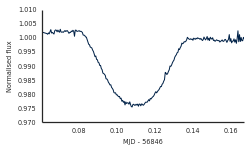

In [23]:
with sb.plotting_context('paper', rc=rc_paper):
    fig,ax = subplots(1,1, figsize=(AAOCW,0.6*AAOCW))
    plot(time, normalise(lc_bb_2_nomask/lc_bb_1_nomask), c=c_ob)
    setp(ax, xlim=time[[0,-1]], ylim=(0.97,1.01), ylabel='Normalised flux', 
         xlabel='MJD - {:5.0f}'.format(floor(df_aux.mjd[0])))
    fig.tight_layout()
    sb.despine(fig)
    fig.savefig('plots/pub_lc_bb_rel.pdf')

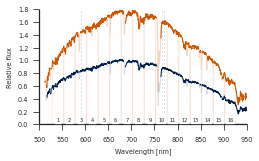

In [24]:
df = 81000.
sc,st = spectra_1[0]/df, spectra_2[0]/df

with sb.plotting_context('paper', rc=rc_paper):
    with sb.axes_style('ticks'):
        fig,ax = subplots(1,1,figsize=(AAOCW,0.6*AAOCW))
        [ax.plot(wl1, f(wl1)*sc, c=c_bo, lw=1, alpha=0.1, zorder=-100) for f in pb_filters_nb]
        ax.plot(wl1, sc, c=c_bo, lw=1, alpha=0.15, zorder=100)
        ax.plot(wl1, where(m1, sc, nan), c=c_bo, lw=1, alpha=1, zorder=100)
        ax.plot(wl2, st, c=c_ob, lw=1, alpha=0.15, zorder=101)
        ax.plot(wl2, where(m2, st, nan), c=c_ob, lw=1, alpha=1, zorder=101)
        [ax.text(pbc, 0.06, i+1, ha='center', size=5, bbox=dict(facecolor='white', edgecolor='white')) 
         for i,pbc in enumerate(pb_centers)]
        [ax.axvline(wlc, c=cp[0], alpha=0.25, ls=':', lw=1, zorder=-100) for wlc in r_[wlc_k,wlc_na]]
        sb.despine(fig)
        setp(ax, xlabel='Wavelength [nm]', xlim=(500,950), ylim=(0,1.8), ylabel='Relative flux')
        fig.subplots_adjust(left=0.13, right=0.96, bottom=0.20, top=0.97)
        fig.savefig('plots/pub_spectra.pdf')

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>